# This document will implement the Chapter 10 models and exercises but will use pytorch instead of tensorflow and keras
## Fashion NIST Simple NN

In pytorch, instead of creating a model like in tensor flow that is stand alone from APIs. It looks like it is more object oriented and uses a class structure instead. 

First step will be to get the fashion data into a format that can be used with the model itself. This requires the creation of Dataset & Dataloader.

Dataset is responsible for accessing and processing single instances of the data. 

While a Dataloader pulls instaces of the data from the Dataset, collects them in batches and returns them for use in training.

Part of the dataset creation, we will normalize the images to be zero centered as these are more efficient to work with causing training loop to be shorter in runtime.

In [1]:
# Import necessary libraries for Dataset and DataLoader
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# Add tensor board support for better visualization of the model we are creating.
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

2024-05-10 09:39:24.662753: E external/local_xla/xla/stream_executor/plugin_registry.cc:93] Invalid plugin kind specified: DNN
2024-05-10 09:39:24.701228: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


With pytorch we can use GPU for faster training speed. Figure out if we can with this code.

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
investigate_mnist_data_shape = torchvision.datasets.FashionMNIST('Data/FashionMNIST', train=True, transform=transforms.ToTensor(), download=True)

In [5]:
# Investigate the size of the data
investigate_mnist_data_shape.data.shape

torch.Size([60000, 28, 28])

The data is 60_000 images of the shape (28, 28). Thus for the normalized transform we need to have to dimensions for the (mean, std))

In [6]:
# We start by creating a transformer function. This will convert the dataset to a tensor and
# apply the normalization to make it 0 centered and standard deviation around 0.5

mean = 0.5

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # Normalize needs a mean for each channel. Being that this is a grayscale we only have one channel
        transforms.Normalize((0.5,), (0.5,))
    ]    
)

training_set = torchvision.datasets.FashionMNIST('Data/FashionMNIST', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('Data/FashionMNIST', train=False, transform=transform, download=True)

We now have our datasets. As the data was already in torchvision we don't need to explicitly create the classes themselves yet.

Now we need to create a DataLoader that will take in this DataSet for both training and validation

In [7]:
batch_size = 4
training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)

Generate our class labels as the FashionMNIST data set does not have any labels, just numbers

In [8]:
# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


To make sure the data is looking like how we should expect we should visualize the data we received using MatPlotLib

Trouser Shirt T-shirt/top Ankle Boot


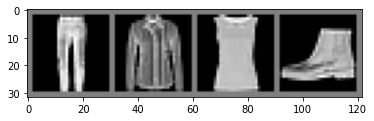

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def display_image(img):
    img = img.mean(dim=0)
    # Remove normalization
    img = img / 2 + 0.5
    # Convert from tensor to np.array
    img_np = img.numpy()
    plt.imshow(img_np, cmap='gray')

# Data iterator of the data loader
data_iter = iter(training_loader)
images, labels = next(data_iter)

# Create a grid of the images to be displayed
img_grid = torchvision.utils.make_grid(images)
display_image(img_grid)

print(' '.join(classes[label] for label in labels))

The labels and the data matches. Sanity Check complete. Good to move forware to setting up the model

In [11]:
# import neural network and activation function libraries
import torch.nn as nn
import torch.nn.functional as F

In [12]:
# Pytorch models are created by inheriting nn.Module
class FashionClassifier(nn.Module):
    def __init__(self):
        super(FashionClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
            nn.Linear(28*28, 300),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.sequential(x)
        return logits

In [15]:
model = FashionClassifier()
model = FashionClassifier().to(device)
print(model)

FashionClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sequential): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
    (5): Softmax(dim=1)
  )
)


Woot, model looks fairly similar to the model we created in the TensorFlow Document

Now it is time to train the model. In pytorch the steps are more drawn out. Instead of doing fit like in tensorflow we need to list each step in the training loop and make the loop as well

In [16]:
# Get loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Get Optimizer, Using Parameters from tensorflow example
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

For the training loop the general flow is as follows:
1. Get a batch of data from Dataloader
2. Zero optimizer's gradient
3. Query model for predictions
4. Calculate loss between predictions and labels
5. Calculate backward gradients over the learning weights
6. Tell the optimizer to perform 1 step to adjust the weights based on the backwards gradients
7. Report on loss and average loss every to often to see it is working (1_000 batches) and not too often to cause too much non-gpu time.

In [17]:
# One epoch training function
def one_epoch_training(epoch_index, tb_writer):
    '''
        Parameters:
            epoch_index: Specifies the current epoch being trained
            tb_writer: Specifies the TensorBoard Writer for visualization

        Returns:
            Final loss value for epoch
    '''
    running_loss = 0.
    final_loss = 0.
    total_correct = 0
    total_samples = 0

    # Loop through all batches of images 
    for i, data in enumerate(training_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)
        _, predicted = torch.max(predictions, 1)

        loss = loss_fn(predictions, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        # Update the running total of correct predictions and samples
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        if i % 1000 == 999:
            final_loss = running_loss / 1000 # loss per batch
            accuracy = 100 * total_correct / total_samples
            print(f' batch {i+1} lost: {final_loss} accuracy: {accuracy}')
            images_trained = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train/accuracy', final_loss, images_trained, accuracy)
            running_loss = 0.

    accuracy = 100 * total_correct / total_samples
    return final_loss, accuracy

In [18]:
# Actual training loop: Equivalent to tensorflow.fit
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

EPOCHS = 30

best_vloss = 1_000_000

for epoch in range(EPOCHS):
    print(f'EPOCH {epoch+1}:')

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss, accuracy = one_epoch_training(epoch, writer)

    running_vloss = 0.0

    # Set the model to evaluation mode, disabling dropout and using population statistics for batch normalization
    model.eval()

    # Disable gradient computation and reduce memory consumption
    # Calculate validation loss here
    with torch.no_grad():
        vcorrect = 0
        vsamples = 0
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)
            vpredictions = model(vinputs)
            _, vpredict = torch.max(vpredictions, 1)
            vloss = loss_fn(vpredictions, vlabels)
            running_vloss += vloss
            vcorrect += (vpredict == vlabels).sum().item()
            vsamples += vlabels.size(0)

    vaccuracy = 100 * vcorrect / vsamples
    avg_vloss = running_vloss / (i + 1)
    print(f'LOSS train {avg_loss}, valid {avg_vloss}')
    print(f'ACCURACY train {accuracy}, valid {vaccuracy}')

    writer.add_scalars('Training vs. Validation Loss', {
        'Training' : avg_loss, 'Validation' : avg_vloss
    }, epoch + 1)
    writer.add_scalars('Training vs. Validation Accuracy', {
        'Training' : accuracy, 'Validation' : vaccuracy
    }, epoch + 1)
    writer.flush()

    # Track best performance, and save the best model state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f'Models/FashionMNIST/fashion_model_{timestamp}_{epoch}'
        torch.save(model.state_dict(), model_path)
    

EPOCH 1:
 batch 1000 lost: 2.2449551124572755 accuracy: 27.675
 batch 2000 lost: 1.9876223553419112 accuracy: 39.825
 batch 3000 lost: 1.7985867702960967 accuracy: 50.05
 batch 4000 lost: 1.7526023719310762 accuracy: 55.85
 batch 5000 lost: 1.7265358922481537 accuracy: 59.63
 batch 6000 lost: 1.7182517342567445 accuracy: 62.24166666666667
 batch 7000 lost: 1.706599822640419 accuracy: 64.23571428571428
 batch 8000 lost: 1.706416628241539 accuracy: 65.765625
 batch 9000 lost: 1.6912328671216965 accuracy: 67.09166666666667
 batch 10000 lost: 1.6833318072557448 accuracy: 68.2525
 batch 11000 lost: 1.6913210563659669 accuracy: 69.125
 batch 12000 lost: 1.6793804508447647 accuracy: 69.9375
 batch 13000 lost: 1.6864187961816788 accuracy: 70.5576923076923
 batch 14000 lost: 1.6819465032815932 accuracy: 71.1125
 batch 15000 lost: 1.6724706066846848 accuracy: 71.67166666666667
LOSS train 1.6724706066846848, valid 1.680990219116211
ACCURACY train 71.67166666666667, valid 78.29
EPOCH 2:
 batch 100

 batch 5000 lost: 1.6334683166742325 accuracy: 82.905
 batch 6000 lost: 1.6314189043045044 accuracy: 82.94166666666666
 batch 7000 lost: 1.6276137920618057 accuracy: 82.99285714285715
 batch 8000 lost: 1.6289863377809524 accuracy: 83.04375
 batch 9000 lost: 1.625151030898094 accuracy: 83.125
 batch 10000 lost: 1.6255769392251969 accuracy: 83.1725
 batch 11000 lost: 1.6371475266218185 accuracy: 83.10909090909091
 batch 12000 lost: 1.6381079621315002 accuracy: 83.03958333333334
 batch 13000 lost: 1.6419566210508347 accuracy: 82.95192307692308
 batch 14000 lost: 1.631481862783432 accuracy: 82.95714285714286
 batch 15000 lost: 1.6315387135744095 accuracy: 82.97166666666666
LOSS train 1.6315387135744095, valid 1.6418797969818115
ACCURACY train 82.97166666666666, valid 81.94
EPOCH 10:
 batch 1000 lost: 1.636652727007866 accuracy: 82.575
 batch 2000 lost: 1.6206487760543824 accuracy: 83.3375
 batch 3000 lost: 1.6387861504554748 accuracy: 82.98333333333333
 batch 4000 lost: 1.6287572388648988 

 batch 8000 lost: 1.6358435410261154 accuracy: 84.021875
 batch 9000 lost: 1.6197460980415344 accuracy: 84.04722222222222
 batch 10000 lost: 1.624627382516861 accuracy: 84.0075
 batch 11000 lost: 1.6114849928617478 accuracy: 84.09772727272727
 batch 12000 lost: 1.6166605832576753 accuracy: 84.14166666666667
 batch 13000 lost: 1.6259600692987441 accuracy: 84.09423076923076
 batch 14000 lost: 1.6233221871852874 accuracy: 84.08035714285714
 batch 15000 lost: 1.6195814930200576 accuracy: 84.09
LOSS train 1.6195814930200576, valid 1.6363716125488281
ACCURACY train 84.09, valid 82.48
EPOCH 18:
 batch 1000 lost: 1.6271648434400559 accuracy: 83.475
 batch 2000 lost: 1.6343629977703094 accuracy: 83.025
 batch 3000 lost: 1.609415134191513 accuracy: 83.7
 batch 4000 lost: 1.6198739347457887 accuracy: 83.78125
 batch 5000 lost: 1.6000914902687073 accuracy: 84.27
 batch 6000 lost: 1.6082959698438644 accuracy: 84.45833333333333
 batch 7000 lost: 1.6124256856441497 accuracy: 84.52142857142857
 batch 

 batch 11000 lost: 1.603282165288925 accuracy: 84.68636363636364
 batch 12000 lost: 1.6108240818977355 accuracy: 84.70833333333333
 batch 13000 lost: 1.6033366725444793 accuracy: 84.80192307692307
 batch 14000 lost: 1.6117763985395432 accuracy: 84.81964285714285
 batch 15000 lost: 1.6084356726408005 accuracy: 84.86
LOSS train 1.6084356726408005, valid 1.6313750743865967
ACCURACY train 84.86, valid 82.93
EPOCH 26:
 batch 1000 lost: 1.6047080523967743 accuracy: 85.675
 batch 2000 lost: 1.6154096392393111 accuracy: 85.1
 batch 3000 lost: 1.6023183507919312 accuracy: 85.39166666666667
 batch 4000 lost: 1.6114462589025498 accuracy: 85.3
 batch 5000 lost: 1.6168711190223695 accuracy: 85.13
 batch 6000 lost: 1.6009796509742737 accuracy: 85.3
 batch 7000 lost: 1.608482966899872 accuracy: 85.30357142857143
 batch 8000 lost: 1.6049316502809525 accuracy: 85.35
 batch 9000 lost: 1.6011674646139145 accuracy: 85.43055555555556
 batch 10000 lost: 1.6154028750658036 accuracy: 85.3425
 batch 11000 lost

use tensorboard --lodir="runs/" to view accuracy and loss graphs.

Overall the accuracy is similar to the TensorFlow model.

In [19]:
# Fetch california house data
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

# Using previous housing to be consistent with thje book
housing = fetch_california_housing()
cal_x_train_full, cal_x_test, cal_y_train_full, cal_y_test = train_test_split(
    housing.data, housing.target, random_state=42)
cal_x_train, cal_x_val, cal_y_train, cal_y_val = train_test_split(
    cal_x_train_full, cal_y_train_full, random_state=42)

cal_x_train = torch.Tensor(cal_x_train)
cal_y_train = torch.Tensor(cal_y_train)
cal_x_test = torch.Tensor(cal_x_test)
cal_y_test = torch.Tensor(cal_y_test)
cal_x_val = torch.Tensor(cal_x_val)
cal_y_val = torch.Tensor(cal_y_val)
cal_x_train.shape

torch.Size([11610, 8])

In [26]:
labels = labels# Make CustomDataSet

class CalHousingDataSet(torch.utils.data.Dataset):
    def __init__(self, features, values):
        self.features = features
        self.values = values

    def __len__(self):
        return len(self.values)

    def __getitem__(self, index):
        feature = self.features[index]
        feature = (feature - feature.mean()) / feature.std()
        value = self.values[index]
        return feature, value
        
cal_training = CalHousingDataSet(cal_x_train, cal_y_train)
cal_validation = CalHousingDataSet(cal_x_val, cal_y_val)

In [27]:
# Make Data Loaders
batch_size = 32
cal_train_dataloader = torch.utils.data.DataLoader(cal_training, batch_size=batch_size, shuffle=True)
cal_val_dataloader = torch.utils.data.DataLoader(cal_validation, batch_size=batch_size, shuffle=False)

In [28]:
# Create the model

class CalHousingPredictor(nn.Module):
    def __init__(self):
        super(CalHousingPredictor, self).__init__()
        self.sequential = nn.Sequential(
            nn.Linear(8, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        logits = self.sequential(x)
        return logits

cal_housing_model = CalHousingPredictor()
print(cal_housing_model)

CalHousingPredictor(
  (sequential): Sequential(
    (0): Linear(in_features=8, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [29]:
# Choose Loss
cal_loss_fn = torch.nn.MSELoss()

# Choose Optimizer
cal_optim_fn = torch.optim.Adam(cal_housing_model.parameters(), lr=0.001)

In [30]:
# One Epoch Functionality
# One epoch training function
def one_epoch_training_regress(epoch_index, tb_writer):
    '''
        Parameters:
            epoch_index: Specifies the current epoch being trained
            tb_writer: Specifies the TensorBoard Writer for visualization

        Returns:
            Final loss value for epoch
    '''
    running_loss = 0.
    final_loss = 0.
    record_batch = len(cal_train_dataloader) // 3
    
    # Loop through all batches of images 
    for i, data in enumerate(cal_train_dataloader):
        inputs, labels = data
        # inputs = inputs.to(device)
        # labels = labels.to(device)

        cal_optim_fn.zero_grad()

        predictions = cal_housing_model(inputs)

        loss = cal_loss_fn(predictions, labels)
        loss.backward()

        cal_optim_fn.step()

        running_loss += loss.item()
        if i % record_batch == record_batch - 1:
            final_loss = running_loss / 1000 # loss per batch
            print(f' batch {i+1} lost: {final_loss}')
            samples_trained = epoch_index * len(cal_train_dataloader) + i + 1
            tb_writer.add_scalar('Loss/train', final_loss, samples_trained)
            running_loss = 0.

    return final_loss

In [31]:
# Actual training loop: Equivalent to tensorflow.fit
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/cal_housing_{}'.format(timestamp))

EPOCHS = 30

best_vloss = 1_000_000

for epoch in range(EPOCHS):
    print(f'EPOCH {epoch+1}:')

    # Make sure gradient tracking is on, and do a pass over the data
    cal_housing_model.train(True)
    avg_loss = one_epoch_training_regress(epoch, writer)

    running_vloss = 0.0

    # Set the model to evaluation mode, disabling dropout and using population statistics for batch normalization
    cal_housing_model.eval()

    # Disable gradient computation and reduce memory consumption
    # Calculate validation loss here
    with torch.no_grad():
        for i, vdata in enumerate(cal_val_dataloader):
            vinputs, vlabels = vdata
            # vinputs = vinputs.to(device)
            # vlabels = vlabels.to(device)
            vpredictions = cal_housing_model(vinputs)
            vloss = cal_loss_fn(vpredictions, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print(f'LOSS train {avg_loss}, valid {avg_vloss}')

    writer.add_scalars('Training vs. Validation Loss', {
        'Training' : avg_loss, 'Validation' : avg_vloss
    }, epoch + 1)
    writer.flush()

    # Track best performance, and save the best model state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f'Models/CalHousing/cal_housing_model_{timestamp}_{epoch}'
        torch.save(cal_housing_model.state_dict(), model_path)
    

EPOCH 1:
 batch 121 lost: 0.24227539229393005


/home/blake/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


 batch 242 lost: 0.1633368697166443
 batch 363 lost: 0.16275593996047974
LOSS train 0.16275593996047974, valid 1.337125301361084
EPOCH 2:


/home/blake/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/blake/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


 batch 121 lost: 0.1556873790025711
 batch 242 lost: 0.16763301420211793
 batch 363 lost: 0.16673532247543335
LOSS train 0.16673532247543335, valid 1.3183797597885132
EPOCH 3:
 batch 121 lost: 0.16245104098320007
 batch 242 lost: 0.16276346576213838
 batch 363 lost: 0.16379873436689377
LOSS train 0.16379873436689377, valid 1.3300044536590576
EPOCH 4:
 batch 121 lost: 0.163224317073822
 batch 242 lost: 0.16303661799430846
 batch 363 lost: 0.16355230355262756
LOSS train 0.16355230355262756, valid 1.327758550643921
EPOCH 5:
 batch 121 lost: 0.16383348923921584
 batch 242 lost: 0.16200156950950623
 batch 363 lost: 0.1635093767642975
LOSS train 0.1635093767642975, valid 1.3372598886489868
EPOCH 6:
 batch 121 lost: 0.16273825150728224
 batch 242 lost: 0.16817642033100128
 batch 363 lost: 0.15876131051778794
LOSS train 0.15876131051778794, valid 1.3151535987854004
EPOCH 7:
 batch 121 lost: 0.16758970671892165
 batch 242 lost: 0.16548723286390304
 batch 363 lost: 0.1578764048218727
LOSS train 